[Reference](https://miptgirl.medium.com/mining-rules-from-data-4fd9f559c608)

In [1]:
import pandas as pd
pd.set_option('display.max_colwidth', 5000)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

df = pd.read_csv('https://raw.githubusercontent.com/miptgirl/miptgirl_medium/refs/heads/main/mining_rules/bank-full.csv', sep = ';')
df = df.drop(['duration', 'campaign'], axis = 1)
# removed columns related to the current marketing campaign,
# since they introduce data leakage

df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,-1,0,unknown,no


# Data Preprocessing

In [2]:
for p in ['default', 'housing', 'loan', 'y']:
    df[p] = df[p].map(lambda x: 1 if x == 'yes' else 0)

In [3]:
month_map = {
    'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6,
    'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12
}
# I saved 5 mins by asking ChatGPT to do this mapping

df['month'] = df.month.map(lambda x: month_map[x] if x in month_map else x)

In [4]:
df['id'] = list(range(df.shape[0]))

In [5]:
fin_df = pd.get_dummies(
  df, columns=['job', 'marital', 'education', 'poutcome', 'contact'],
  dtype = int, # to convert to flags 0/1
  drop_first = False # to keep all possible values
)

In [6]:
fin_df.merge(df[['id', 'poutcome']])\
    .groupby(['poutcome', 'poutcome_unknown', 'poutcome_failure', 'poutcome_other', 'poutcome_success'], as_index = False).y.count()\
    .rename(columns = {'y': 'cases'})\
    .sort_values('cases', ascending = False)

,poutcome,poutcome_unknown,poutcome_failure,poutcome_other,poutcome_success,cases
3,unknown,1,0,0,0,36959
0,failure,0,1,0,0,4901
1,other,0,0,1,0,1840
2,success,0,0,0,1,1511


In [7]:
fin_df = fin_df.drop('id', axis = 1)

In [8]:
feature_names = fin_df.drop(['y'], axis = 1).columns
len(feature_names)

35

# Decision Tree Classifier: Theory

In [11]:
import sklearn.tree
import graphviz

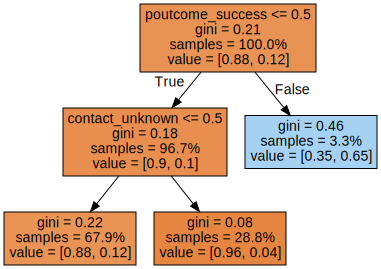

In [12]:

model = sklearn.tree.DecisionTreeClassifier(min_samples_leaf = 1000, max_depth = 2)
model.fit(fin_df[feature_names], fin_df['y'])

dot_data = sklearn.tree.export_graphviz(
    model, out_file=None, feature_names = feature_names, filled = True,
    proportion = True, precision=2, impurity = True)

graph = graphviz.Source(dot_data)
graph

In [13]:
def get_gini(df):
    p = df.y.mean()
    return 2*p*(1-p)

In [14]:
get_gini(fin_df)

np.float64(0.2065987201592864)

In [15]:
def get_gini_comb(df1, df2):
    n1 = df1.shape[0]
    n2 = df2.shape[0]

    gini1 = get_gini(df1)
    gini2 = get_gini(df2)
    return (gini1*n1 + gini2*n2)/(n1 + n2)

In [16]:

import tqdm
def optimise_one_parameter(df, param):
    tmp = []
    possible_values = list(sorted(df[param].unique()))
    print(param)
    for i in tqdm.tqdm(range(1, len(possible_values))):
        threshold = (possible_values[i-1] + possible_values[i])/2
        gini = get_gini_comb(df[df[param] <= threshold], df[df[param] > threshold])
        tmp.append(
            {'param': param, 'threshold': threshold, 'gini': gini,
            'sizes': (df[df[param] <= threshold].shape[0], df[df[param] > threshold].shape[0])}
        )
    return pd.DataFrame(tmp)

In [17]:
tmp_dfs = []
for feature in feature_names:
    tmp_dfs.append(optimise_one_parameter(fin_df, feature))

age


100%|██████████| 76/76 [00:01<00:00, 54.70it/s]


default


100%|██████████| 1/1 [00:00<00:00, 114.85it/s]


balance


100%|██████████| 7167/7167 [01:16<00:00, 93.84it/s]


housing


100%|██████████| 1/1 [00:00<00:00, 48.63it/s]


loan


100%|██████████| 1/1 [00:00<00:00, 74.92it/s]


day


100%|██████████| 30/30 [00:00<00:00, 91.80it/s]


month


100%|██████████| 11/11 [00:00<00:00, 60.85it/s]


pdays


100%|██████████| 558/558 [00:04<00:00, 125.40it/s]


previous


100%|██████████| 40/40 [00:00<00:00, 122.73it/s]


job_admin.


100%|██████████| 1/1 [00:00<00:00, 72.77it/s]


job_blue-collar


100%|██████████| 1/1 [00:00<00:00, 73.90it/s]


job_entrepreneur


100%|██████████| 1/1 [00:00<00:00, 69.61it/s]


job_housemaid


100%|██████████| 1/1 [00:00<00:00, 83.13it/s]


job_management


100%|██████████| 1/1 [00:00<00:00, 73.44it/s]


job_retired


100%|██████████| 1/1 [00:00<00:00, 76.34it/s]


job_self-employed


100%|██████████| 1/1 [00:00<00:00, 78.96it/s]


job_services


100%|██████████| 1/1 [00:00<00:00, 63.81it/s]


job_student


100%|██████████| 1/1 [00:00<00:00, 69.33it/s]


job_technician


100%|██████████| 1/1 [00:00<00:00, 67.58it/s]


job_unemployed


100%|██████████| 1/1 [00:00<00:00, 77.13it/s]


job_unknown


100%|██████████| 1/1 [00:00<00:00, 72.02it/s]


marital_divorced


100%|██████████| 1/1 [00:00<00:00, 66.61it/s]


marital_married


100%|██████████| 1/1 [00:00<00:00, 68.32it/s]


marital_single


100%|██████████| 1/1 [00:00<00:00, 69.73it/s]


education_primary


100%|██████████| 1/1 [00:00<00:00, 67.96it/s]


education_secondary


100%|██████████| 1/1 [00:00<00:00, 56.88it/s]


education_tertiary


100%|██████████| 1/1 [00:00<00:00, 55.39it/s]


education_unknown


100%|██████████| 1/1 [00:00<00:00, 70.06it/s]


poutcome_failure


100%|██████████| 1/1 [00:00<00:00, 75.69it/s]

poutcome_other

100%|██████████| 1/1 [00:00<00:00, 77.33it/s]


poutcome_success


100%|██████████| 1/1 [00:00<00:00, 79.12it/s]


poutcome_unknown


100%|██████████| 1/1 [00:00<00:00, 40.39it/s]

contact_cellular

100%|██████████| 1/1 [00:00<00:00, 41.82it/s]


contact_telephone


100%|██████████| 1/1 [00:00<00:00, 65.44it/s]


contact_unknown


100%|██████████| 1/1 [00:00<00:00, 50.15it/s]


In [18]:
opt_df = pd.concat(tmp_dfs)
opt_df.sort_values('gini', ascending = True).head()

,param,threshold,gini,sizes
0,poutcome_success,0.50,0.19,"(43700, 1511)"
8,pdays,8.50,0.20,"(37062, 8149)"
9,pdays,9.50,0.20,"(37074, 8137)"
11,pdays,12.50,0.20,"(37087, 8124)"
17,pdays,19.50,0.20,"(37112, 8099)"


In [19]:
tmp_dfs = []
for feature in feature_names:
    tmp_dfs.append(optimise_one_parameter(
      fin_df[fin_df.poutcome_success <= 0.5], feature))
opt_df = pd.concat(tmp_dfs)

age


100%|██████████| 75/75 [00:00<00:00, 125.94it/s]


default


100%|██████████| 1/1 [00:00<00:00, 89.30it/s]


balance


100%|██████████| 7167/7167 [01:11<00:00, 99.83it/s] 


housing


100%|██████████| 1/1 [00:00<00:00, 78.95it/s]


loan


100%|██████████| 1/1 [00:00<00:00, 100.62it/s]


day


100%|██████████| 30/30 [00:00<00:00, 140.88it/s]


month


100%|██████████| 11/11 [00:00<00:00, 144.13it/s]


pdays


100%|██████████| 533/533 [00:04<00:00, 117.83it/s]


previous


100%|██████████| 40/40 [00:00<00:00, 119.22it/s]


job_admin.


100%|██████████| 1/1 [00:00<00:00, 99.79it/s]


job_blue-collar


100%|██████████| 1/1 [00:00<00:00, 98.95it/s]


job_entrepreneur


100%|██████████| 1/1 [00:00<00:00, 118.07it/s]


job_housemaid


100%|██████████| 1/1 [00:00<00:00, 102.02it/s]


job_management


100%|██████████| 1/1 [00:00<00:00, 103.33it/s]


job_retired


100%|██████████| 1/1 [00:00<00:00, 108.28it/s]


job_self-employed


100%|██████████| 1/1 [00:00<00:00, 100.06it/s]


job_services


100%|██████████| 1/1 [00:00<00:00, 100.92it/s]


job_student


100%|██████████| 1/1 [00:00<00:00, 112.76it/s]


job_technician


100%|██████████| 1/1 [00:00<00:00, 102.04it/s]


job_unemployed


100%|██████████| 1/1 [00:00<00:00, 109.60it/s]


job_unknown


100%|██████████| 1/1 [00:00<00:00, 114.58it/s]


marital_divorced


100%|██████████| 1/1 [00:00<00:00, 97.21it/s]


marital_married


100%|██████████| 1/1 [00:00<00:00, 102.53it/s]


marital_single


100%|██████████| 1/1 [00:00<00:00, 78.84it/s]


education_primary


100%|██████████| 1/1 [00:00<00:00, 84.35it/s]


education_secondary


100%|██████████| 1/1 [00:00<00:00, 87.87it/s]


education_tertiary


100%|██████████| 1/1 [00:00<00:00, 94.80it/s]


education_unknown


100%|██████████| 1/1 [00:00<00:00, 104.22it/s]


poutcome_failure


100%|██████████| 1/1 [00:00<00:00, 105.85it/s]


poutcome_other


100%|██████████| 1/1 [00:00<00:00, 119.23it/s]


poutcome_success


0it [00:00, ?it/s]


poutcome_unknown


100%|██████████| 1/1 [00:00<00:00, 114.34it/s]


contact_cellular


100%|██████████| 1/1 [00:00<00:00, 121.15it/s]


contact_telephone


100%|██████████| 1/1 [00:00<00:00, 76.47it/s]


contact_unknown


100%|██████████| 1/1 [00:00<00:00, 110.56it/s]


In [20]:
opt_df.sort_values('gini', ascending = True).head(5)

,param,threshold,gini,sizes
42,age,60.50,0.17,"(42711, 989)"
43,age,61.50,0.17,"(42830, 870)"
0,contact_unknown,0.50,0.17,"(30692, 13008)"
44,age,62.50,0.18,"(42892, 808)"
45,age,63.50,0.18,"(42957, 743)"


In [21]:
model = sklearn.tree.DecisionTreeClassifier(min_samples_leaf = 1000, min_impurity_decrease=0.001)
model.fit(fin_df[feature_names], fin_df['y'])

dot_data = sklearn.tree.export_graphviz(
    model, out_file=None, feature_names = feature_names, filled = True,
    proportion = True, precision=2, impurity = True)

graph = graphviz.Source(dot_data)

png_bytes = graph.pipe(format='png')
with open('decision_tree.png','wb') as f:
    f.write(png_bytes)

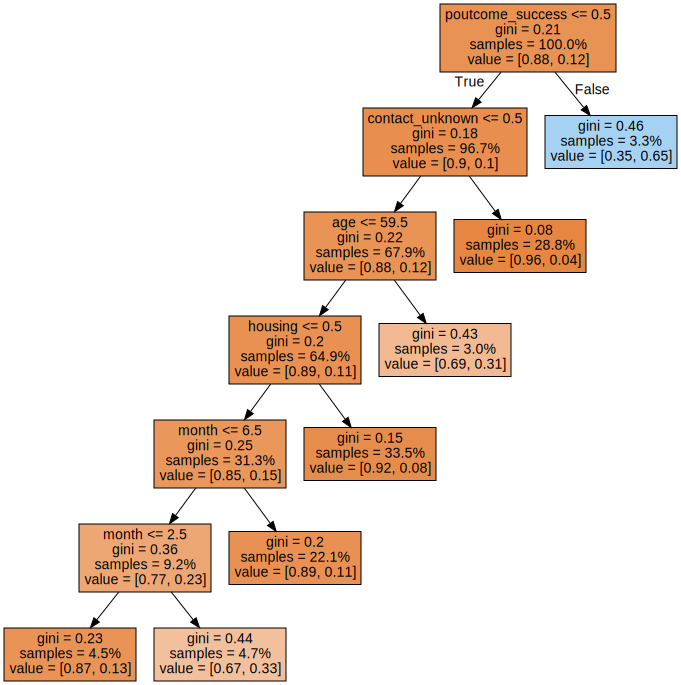

In [22]:
graph

In [23]:
n_nodes = model.tree_.node_count
n_nodes

13

In [24]:
children_left = model.tree_.children_left
children_right = model.tree_.children_right
children_left, children_right

(array([ 1,  2,  3,  4,  5,  6, -1, -1, -1, -1, -1, -1, -1], dtype=int64),
 array([12, 11, 10,  9,  8,  7, -1, -1, -1, -1, -1, -1, -1], dtype=int64))

In [25]:
features = model.tree_.feature
features

array([30, 34,  0,  3,  6,  6, -2, -2, -2, -2, -2, -2, -2], dtype=int64)

In [26]:
thresholds = model.tree_.threshold
thresholds

array([ 0.5,  0.5, 59.5,  0.5,  6.5,  2.5, -2. , -2. , -2. , -2. , -2. ,
       -2. , -2. ])

In [27]:
values = model.tree_.value
values

array([[[0.8830152 , 0.1169848 ]],

       [[0.90135011, 0.09864989]],

       [[0.87671054, 0.12328946]],

       [[0.88550191, 0.11449809]],

       [[0.8530886 , 0.1469114 ]],

       [[0.76686675, 0.23313325]],

       [[0.87043351, 0.12956649]],

       [[0.66619318, 0.33380682]],

       [[0.889     , 0.111     ]],

       [[0.91578184, 0.08421816]],

       [[0.68768328, 0.31231672]],

       [[0.95948647, 0.04051353]],

       [[0.35274653, 0.64725347]]])

In [28]:
num_nodes = model.tree_.n_node_samples
num_nodes

array([45211, 43700, 30692, 29328, 14165,  4165,  2053,  2112, 10000,
       15163,  1364, 13008,  1511], dtype=int64)

In [29]:
hierarchy = {}

for node_id in range(n_nodes):
    # print(node_id, '->', children_left[node_id], children_right[node_id])
    if children_left[node_id] != -1:
        hierarchy[children_left[node_id]] = {'parent': node_id, 'condition': 'left'}
    if children_right[node_id] != -1:
        hierarchy[children_right[node_id]] = {'parent': node_id, 'condition': 'right'}


In [30]:
hierarchy

{np.int64(1): {'parent': 0, 'condition': 'left'},
 np.int64(12): {'parent': 0, 'condition': 'right'},
 np.int64(2): {'parent': 1, 'condition': 'left'},
 np.int64(11): {'parent': 1, 'condition': 'right'},
 np.int64(3): {'parent': 2, 'condition': 'left'},
 np.int64(10): {'parent': 2, 'condition': 'right'},
 np.int64(4): {'parent': 3, 'condition': 'left'},
 np.int64(9): {'parent': 3, 'condition': 'right'},
 np.int64(5): {'parent': 4, 'condition': 'left'},
 np.int64(8): {'parent': 4, 'condition': 'right'},
 np.int64(6): {'parent': 5, 'condition': 'left'},
 np.int64(7): {'parent': 5, 'condition': 'right'}}

In [31]:
leaves = []
for node_id in range(n_nodes):
    if (children_left[node_id] == -1) and (children_right[node_id] == -1):
        leaves.append(node_id)

In [32]:
leaves

[6, 7, 8, 9, 10, 11, 12]

In [33]:
leaves_df = pd.DataFrame({'node_id': leaves})
leaves_df

,node_id
0,6
1,7
2,8
3,9
4,10
5,11
6,12


In [34]:
def get_condition(node_id, condition, features, thresholds, feature_names):
    # print(node_id, condition)
    feature = feature_names[features[node_id]]
    threshold = thresholds[node_id]
    cond = '>' if condition == 'right'  else '<='
    return (feature, cond, threshold)

In [35]:
get_condition(0, 'left', features, thresholds, feature_names)

('poutcome_success', '<=', np.float64(0.5))

In [36]:
get_condition(0, 'right', features, thresholds, feature_names)

('poutcome_success', '>', np.float64(0.5))

In [37]:
def get_decision_path_rec(node_id, decision_path, hierarchy):
    if node_id == 0:
        yield decision_path
    else:
        parent_id = hierarchy[node_id]['parent']
        condition = hierarchy[node_id]['condition']
        for res in get_decision_path_rec(parent_id, decision_path + [(parent_id, condition)], hierarchy):
            yield res

decision_path = list(get_decision_path_rec(12, [], hierarchy))[0]
print(decision_path)
fmt_decision_path = list(map(lambda x: get_condition(x[0], x[1], features, thresholds, feature_names), decision_path))
print(fmt_decision_path)

[(0, 'right')]
[('poutcome_success', '>', np.float64(0.5))]


In [38]:
def get_decision_path(node_id, features, thresholds, hierarchy, feature_names):
  decision_path = list(get_decision_path_rec(node_id, [], hierarchy))[0]
  return list(map(lambda x: get_condition(x[0], x[1], features, thresholds, feature_names), decision_path))

In [39]:
def get_decision_path_string(node_id, features, thresholds, hierarchy, feature_names):
  conditions_df = pd.DataFrame(get_decision_path(node_id, features, thresholds, hierarchy, feature_names))
  conditions_df.columns = ['feature', 'condition', 'threshold']

  left_conditions_df = conditions_df[conditions_df.condition == '<=']
  right_conditions_df = conditions_df[conditions_df.condition == '>']

  # deduplication
  left_conditions_df = left_conditions_df.groupby(['feature', 'condition'], as_index = False).min()
  right_conditions_df = right_conditions_df.groupby(['feature', 'condition'], as_index = False).max()

  # concatination
  fin_conditions_df = pd.concat([left_conditions_df, right_conditions_df])\
      .sort_values(['feature', 'condition'], ascending = False)
  # formatting
  fin_conditions_df['cond_string'] = list(map(
      lambda x, y, z: '(%s %s %.2f)' % (x, y, z),
      fin_conditions_df.feature,
      fin_conditions_df.condition,
      fin_conditions_df.threshold
  ))
  return ' and '.join(fin_conditions_df.cond_string.values)

In [40]:
get_decision_path_string(12, features, thresholds, hierarchy, feature_names)

'(poutcome_success > 0.50)'

In [41]:
leaves_df['condition'] = leaves_df['node_id'].map(
  lambda x: get_decision_path_string(x, features, thresholds, hierarchy, feature_names)
)

In [42]:
leaves_df

,node_id,condition
0,6,(poutcome_success <= 0.50) and (month <= 2.50) and (housing <= 0.50) and (contact_unknown <= 0.50) and (age <= 59.50)
1,7,(poutcome_success <= 0.50) and (month > 2.50) and (month <= 6.50) and (housing <= 0.50) and (contact_unknown <= 0.50) and (age <= 59.50)
2,8,(poutcome_success <= 0.50) and (month > 6.50) and (housing <= 0.50) and (contact_unknown <= 0.50) and (age <= 59.50)
3,9,(poutcome_success <= 0.50) and (housing > 0.50) and (contact_unknown <= 0.50) and (age <= 59.50)
4,10,(poutcome_success <= 0.50) and (contact_unknown <= 0.50) and (age > 59.50)
5,11,(poutcome_success <= 0.50) and (contact_unknown > 0.50)
6,12,(poutcome_success > 0.50)


In [43]:
leaves_df['total'] = leaves_df.node_id.map(lambda x: num_nodes[x])
leaves_df['conversion'] = leaves_df['node_id'].map(lambda x: values[x][0][1])*100
leaves_df['converted_users'] = (leaves_df.conversion * leaves_df.total).map(lambda x: int(round(x/100)))
leaves_df['share_of_converted'] = 100*leaves_df['converted_users']/leaves_df['converted_users'].sum()
leaves_df['share_of_total'] = 100*leaves_df['total']/leaves_df['total'].sum()

In [44]:
leaves_df.sort_values('conversion', ascending = False).drop('node_id', axis = 1).set_index('condition')

,total,conversion,converted_users,share_of_converted,share_of_total
condition,,,,,
(poutcome_success > 0.50),1511,64.73,978,18.49,3.34
(poutcome_success <= 0.50) and (month > 2.50) and (month <= 6.50) and (housing <= 0.50) and (contact_unknown <= 0.50) and (age <= 59.50),2112,33.38,705,13.33,4.67
(poutcome_success <= 0.50) and (contact_unknown <= 0.50) and (age > 59.50),1364,31.23,426,8.05,3.02
(poutcome_success <= 0.50) and (month <= 2.50) and (housing <= 0.50) and (contact_unknown <= 0.50) and (age <= 59.50),2053,12.96,266,5.03,4.54
(poutcome_success <= 0.50) and (month > 6.50) and (housing <= 0.50) and (contact_unknown <= 0.50) and (age <= 59.50),10000,11.10,1110,20.99,22.12
(poutcome_success <= 0.50) and (housing > 0.50) and (contact_unknown <= 0.50) and (age <= 59.50),15163,8.42,1277,24.14,33.54
(poutcome_success <= 0.50) and (contact_unknown > 0.50),13008,4.05,527,9.96,28.77
